# Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import timedelta

def analyze_trade_metric_distribution(
    df, 
    metric_col='price', 
    return_summary=True, 
    plot=True, 
    sort_by='median', 
    plot_type='box'
):
    """
    Visualizes the distribution of a specified metric across trade codes using box/violin plots.

    Parameters:
    - df: DataFrame with 'trade_code' and a numeric metric column (e.g., 'price', 'bookings')
    - metric_col: name of the column to analyze (str)
    - return_summary: whether to return a summary table (bool)
    - plot: whether to show the distribution plot (bool)
    - sort_by: column stat to sort trades on ('mean' or 'median')
    - plot_type: 'box' or 'violin' for the distribution plot type

    Returns:
    - summary_df: DataFrame with basic stats of the metric per trade_code
    """

    # Clean column names for consistency
    df = df.copy()
    df.columns = df.columns.str.strip().str.lower()
    metric_col = metric_col.lower()

    # Validate required columns
    if 'trade_code' not in df.columns or metric_col not in df.columns:
        raise KeyError(f"Missing required columns: 'trade_code' or '{metric_col}'")

    # Compute summary
    summary_df = (
        df.groupby('trade_code')[metric_col]
          .agg(['min', 'max', 'mean', 'median', 'std', 'count'])
    )

    # Sort trade_codes
    trade_order = summary_df.sort_values(sort_by).index.tolist()

    # Plot
    if plot:
        plt.figure(figsize=(18, 6))

        if plot_type == 'box':
            sns.boxplot(data=df, x='trade_code', y=metric_col, order=trade_order)
        elif plot_type == 'violin':
            sns.violinplot(data=df, x='trade_code', y=metric_col, order=trade_order, inner='quartile')

        plt.xticks(rotation=90)
        plt.title(f'{metric_col.capitalize()} Distribution by Trade Code')
        plt.xlabel('Trade Code')
        plt.ylabel(metric_col.capitalize())
        plt.tight_layout()
        plt.show()

    if return_summary:
        return summary_df


In [2]:
def plot_trade_metrics(df, trade_code):
    """
    Plots revenue, price, and bookings over time for a given trade code.
    
    Parameters:
    df (pd.DataFrame): The main dataset containing columns 'date', 'trade_code', 'revenue', 'price', 'bookings'.
    trade_code (str): The trade code to filter and plot.
    """
    # Filter and sort
    df_trade = df[df['trade_code'] == trade_code].copy()
    df_trade['date'] = pd.to_datetime(df_trade['date'])
    df_trade = df_trade.sort_values('date')

    # Check if trade_code exists
    if df_trade.empty:
        print(f"No data found for trade_code: {trade_code}")
        return

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axs[0].plot(df_trade['date'], df_trade['revenue'], marker='o')
    axs[0].set_title(f'Trade {trade_code} - Revenue Over Time')
    axs[0].set_ylabel('Revenue')

    axs[1].plot(df_trade['date'], df_trade['price'], marker='o', color='orange')
    axs[1].set_title(f'Trade {trade_code} - Price Over Time')
    axs[1].set_ylabel('Price')

    axs[2].plot(df_trade['date'], df_trade['bookings'], marker='o', color='green')
    axs[2].set_title(f'Trade {trade_code} - Bookings Over Time')
    axs[2].set_ylabel('Bookings')
    axs[2].set_xlabel('Date')

    plt.tight_layout()
    plt.show()


In [3]:
import matplotlib.pyplot as plt

def plot_price_vs_bookings(df, trade_code):
    # Filter for the selected trade code
    df_filtered = df[df['trade_code'] == trade_code]
    
    # Guard clause if no data
    if df_filtered.empty:
        print(f"No data found for trade code: {trade_code}")
        return

    # Sort by price (optional, for smooth line plot)
    df_filtered = df_filtered.sort_values('price')

    # Plot
    plt.figure(figsize=(8, 5))
    plt.scatter(df_filtered['price'], df_filtered['bookings'])
    plt.title(f"Price vs Bookings for Trade Code: {trade_code}")
    plt.xlabel("Price")
    plt.ylabel("Bookings")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [4]:
df = pd.read_csv("pricing_treatment.csv", parse_dates=["date"])
print(df.head())



                       date trade_code  treatment  searches    price  \
0 2025-01-01 00:00:00+00:00         A1    control      5383  2183.32   
1 2025-01-01 00:00:00+00:00         A6    control      4356  1908.68   
2 2025-01-01 00:00:00+00:00         A7  treatment     13958  2869.53   
3 2025-01-01 00:00:00+00:00         A8    control     10658  3885.71   
4 2025-01-01 00:00:00+00:00         B2  treatment     22362  5248.37   

   bookings     revenue  
0       254   554564.55  
1       270   515343.52  
2       358  1027290.01  
3       302  1173484.42  
4       665  3490169.32  


In [5]:
# Check Intraday price variations
# Extract date part
df["date_only"] = df["date"].dt.normalize()     # 2025-01-01 00:00:00+00:00


# Group by trade_code and date_only to check for duplicates
group_cols = ["trade_code", "date_only"]
dupe_counts = (
    df.groupby(group_cols, observed=True)
      .size()
      .reset_index(name="count")
)

# Show only trade-dates that appear more than once
multi_entries = dupe_counts[dupe_counts['count'] > 1]

# Check for variation in price or treatment within same trade-date
variation_check = (
    df.groupby(group_cols)
      .agg(
          price_nunique=('price', 'nunique')
      ).query("price_nunique > 1")
)

# Show result
print("Trade-dates with >1 entry:", len(multi_entries))
print("Trade-dates with within-day variation in price/treatment/searches:\n", variation_check)


Trade-dates with >1 entry: 0
Trade-dates with within-day variation in price/treatment/searches:
 Empty DataFrame
Columns: [price_nunique]
Index: []


In [6]:
# Check the number of trade codes
unique_count = df['trade_code'].nunique()
unique_count

54

In [7]:
#Check
# Step 1: Group by trade code, get unique treatment values
treatment_counts = df.groupby('trade_code')['treatment'].nunique()

# Step 2: Find trade codes with both 'control' and 'treatment'
both_groups = treatment_counts[treatment_counts > 1]

# Step 3: View result
print("Trade codes in both treatment and control:")
print(both_groups.index.tolist())


Trade codes in both treatment and control:
[]


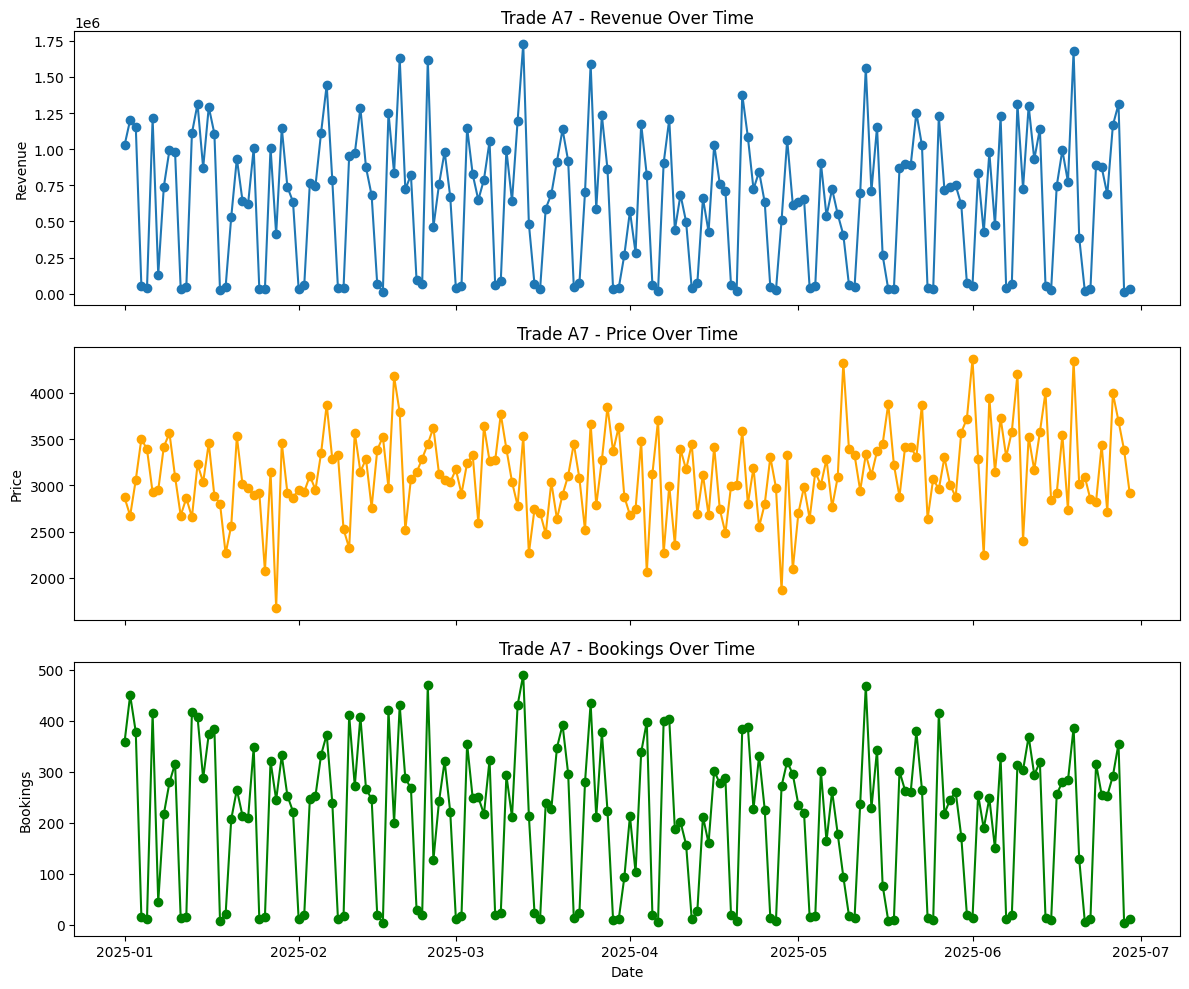

In [8]:
plot_trade_metrics(df, 'A7')  # Replace with any other trade code like 'A1', 'B2', etc.


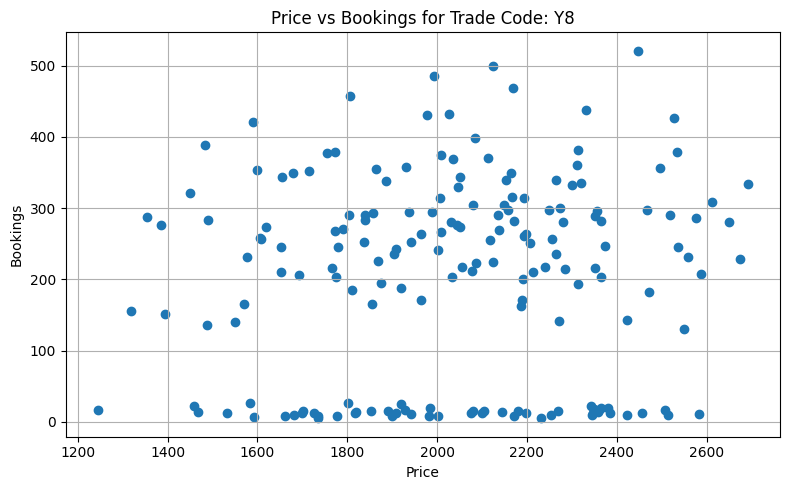

In [9]:
plot_price_vs_bookings(df, 'Y8')


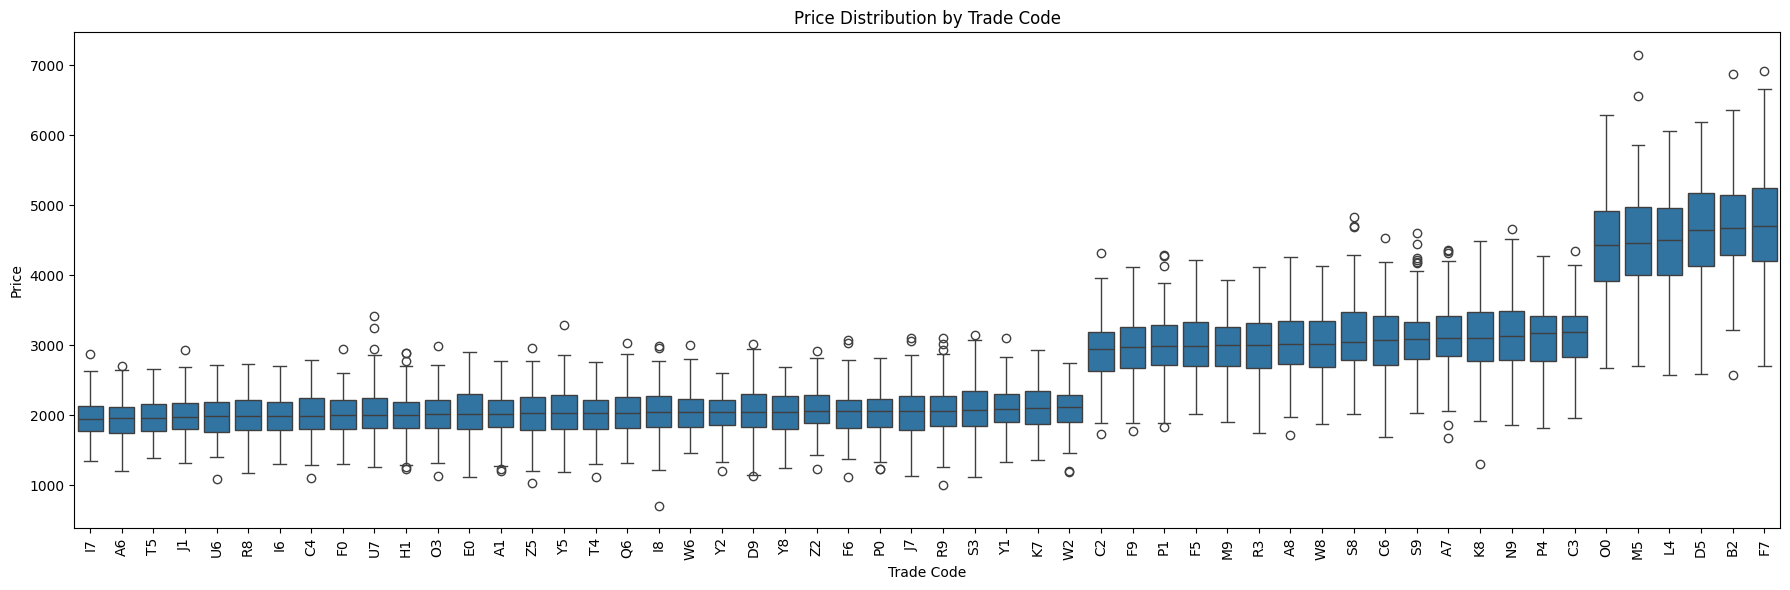

In [10]:
price_summary = analyze_trade_metric_distribution(df, metric_col='price')

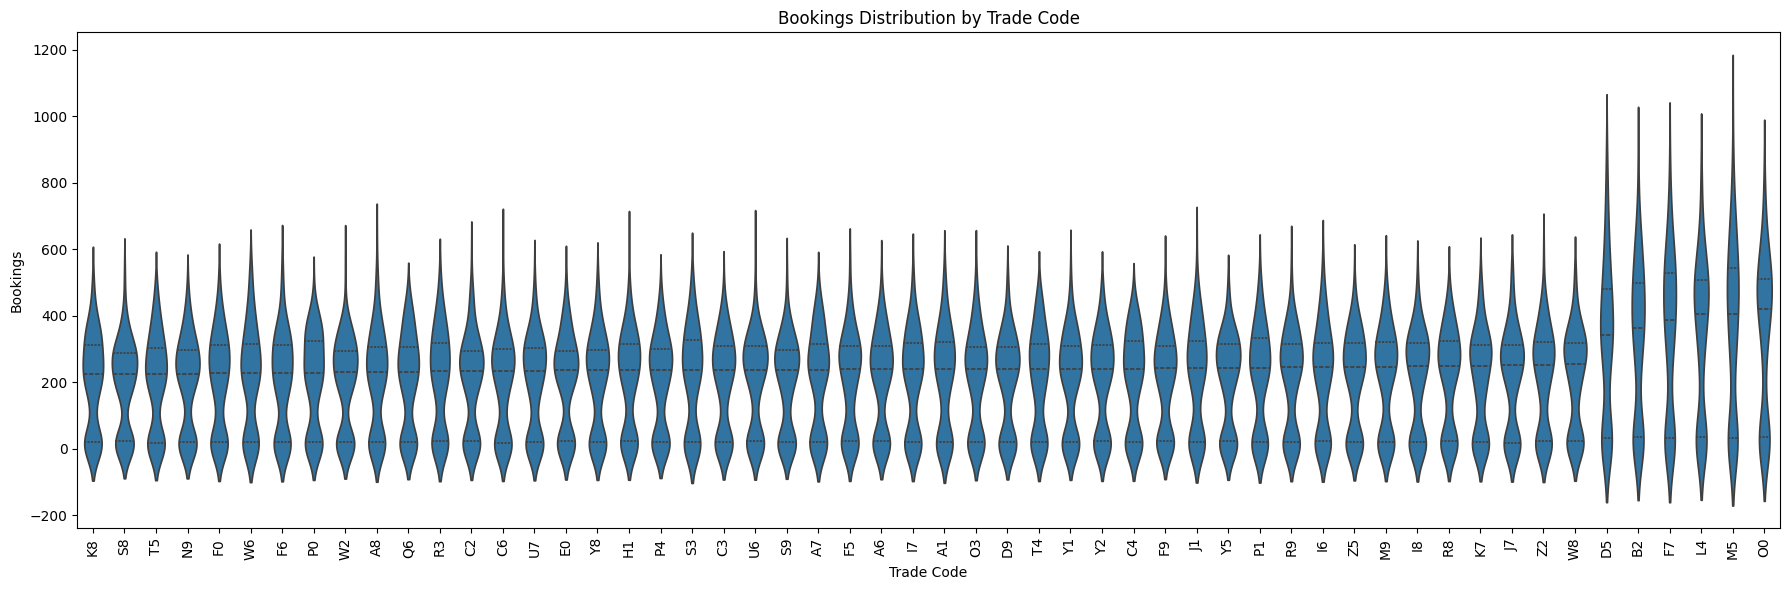

In [11]:

bookings_summary = analyze_trade_metric_distribution(df, metric_col='bookings', plot_type='violin')

